# Домашнее задание 2. Классификация изображений.

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в есть датасете. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train/ и val/, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат, собственно, сами изображения.
 
__Задание__. Необходимо выполнить два задания

1) Добейтесь accuracy **на валидации не менее 0.44**. В этом задании **запрещено** пользоваться предобученными моделями и ресайзом картинок. 5 баллов

2) Добейтесь accuracy **на валидации не менее 0.84**. В этом задании делать ресайз и использовать претрейн можно. 5 баллов

Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи / блогпосты / вопросы на stackoverflow / видосы от ютуберов-машинлернеров / курсы / подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете. 

Ваш код обязательно должен проходить все `assert`'ы ниже.

__Использовать внешние данные для обучения строго запрещено в обоих заданиях. Также запрещено обучаться на валидационной выборке__.


__Критерии оценки__: Оценка вычисляется по простой формуле: `min(10, 10 * Ваша accuracy / 0.44)` для первого задания и `min(10, 10 * (Ваша accuracy - 0.5) / 0.34)` для второго. Оценка округляется до десятых по арифметическим правилам.


__Советы и указания__:
 - Наверняка вам потребуется много гуглить о классификации и о том, как заставить её работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать :)
 - Используйте аугментации. Для этого пользуйтесь модулем `torchvision.transforms` или библиотекой [albumentations](https://github.com/albumentations-team/albumentations)
 - Можно обучать с нуля или файнтюнить (в зависимости от задания) модели из `torchvision`.
 - Рекомендуем написать вам сначала класс-датасет (или воспользоваться классом `ImageFolder`), который возвращает картинки и соответствующие им классы, а затем функции для трейна по шаблонам ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду и повысит вероятность вызова на защиту :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы быстро отладить код, пробуйте обучаться на маленькой части датасета (скажем, 5-10 картинок просто чтобы убедиться что код запускается). Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Советуем использовать GPU. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе. Авторское решение задания достигает требуемой точности в колабе за 15 минут обучения.
 
Good luck & have fun! :)

**Используй первый api key для первого задания, а второй для второго**

In [4]:
!wandb login --relogin a2dc766b5c6799eaa72000ced94146eb5a951020

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\pld02/.netrc


In [7]:
!wandb login

wandb: Currently logged in as: lentohrastik. Use `wandb login --relogin` to force relogin


In [6]:
# Возможно ниже будет не очень работать WandbLogger с первого разу, перезапустите kernel тетрадки
import wandb

wandb.login()

True

In [8]:
import math
import os
import random
import sys
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import RandomApply, Compose, Normalize, Resize, ToTensor, RandomGrayscale, RandomHorizontalFlip, RandomRotation, RandomVerticalFlip, GaussianBlur, RandomInvert
from torchvision.models import resnet152, ResNet50_Weights, densenet121, vgg16, densenet161

from PIL import Image
from torchmetrics.functional import accuracy
from tqdm import tqdm

from pytorch_pretrained_vit import ViT

import warnings
%matplotlib inline
warnings.filterwarnings("ignore")

In [9]:
def seed_everything(seed):
    # Фискирует максимум сидов.
    # Это понадобится, чтобы сравнение оптимизаторов было корректным
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(123456)

## Задание 0

### Что поможет сделать на 10 из 10 (одно задание - 5 баллов)

1. Использовать все возможные методы оптимизации и эксперемнтировать с ними.
2. Подбор learning rate. Пример из прошлого семинара как это делать: [Как найти lr](https://pytorch-lightning.readthedocs.io/en/1.4.5/advanced/lr_finder.html)

```
  trainer = pl.Trainer(accelerator="gpu", max_epochs=2, auto_lr_find=True) 

  trainer.tune(module, train_dataloader, eval_dataloader)

  trainer.fit(module, train_dataloader, eval_dataloader))
```



3. Аугментация данных. [Документация (полезная)](https://pytorch.org/vision/main/transforms.html), а также [библиотека albumentation](https://towardsdatascience.com/getting-started-with-albumentation-winning-deep-learning-image-augmentation-technique-in-pytorch-47aaba0ee3f8)
4. Подбор архитектуры модели. 
5. Можно написать модель руками свою в YourNet, а можно импортировать не предобученную сетку известной архитектуры из модуля torchvision.models. Один из способов как можно сделать: 

  * `torchvision.models.resnet18(pretrained=False, num_classes=200).to(device)`
  * Документация по возможным моделям и как их можно брать: [Документация (полезная)](https://pytorch.org/vision/stable/models.html)
6. Правильно нормализовывать данные при создании, пример [тык, но тут и в целом гайд от и до](https://www.pluralsight.com/guides/image-classification-with-pytorch)
7. Model Checkpointing. Сохраняйте свой прогресс (модели), чтобы когда что-то пойдет не так вы сможете начать с этого места или просто воспроизвести свои результаты модели, которые обучали. 
 * Пример как можно с wandb тут: [Сохраняем лучшие модели в wandb](https://docs.wandb.ai/guides/integrations/lightning)
 * По простому можно так: [Сохраняем модели в pytorch дока](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

### Подготовка данных

In [10]:
mean = torch.tensor([0., 0., 0.])
std = torch.tensor([0., 0., 0.])
count = 0
for class_path in os.listdir('dataset/dataset/train'):
    for img_path in os.listdir('dataset/dataset/train/' + class_path):
        img = ToTensor()(Image.open('dataset/dataset/train/' + class_path + '/' + img_path))
        mean += img.mean([1, 2])
        std += img.std([1, 2])
        count += 1
mean /= count
std /= count

In [11]:
batch_size = 128
train_transform = Compose([ToTensor(),
                           #Resize(224) 
                           Normalize(mean, std),
                           RandomHorizontalFlip(0.5),
                           RandomVerticalFlip(0.5),
                           GaussianBlur((5, 5), 0.2)])
val_transform = Compose([ToTensor(),
                         #Resize(224)
                         Normalize(mean, std)])

train_dataset = ImageFolder('dataset/dataset/train', transform=train_transform)
val_dataset = ImageFolder('dataset/dataset/val', transform=val_transform)
# REPLACE ./dataset/dataset WITH THE FOLDER WHERE YOU DOWNLOADED AND UNZIPPED THE DATASET

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [12]:
# Just very simple sanity checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


### Посмотрим на картиночки

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


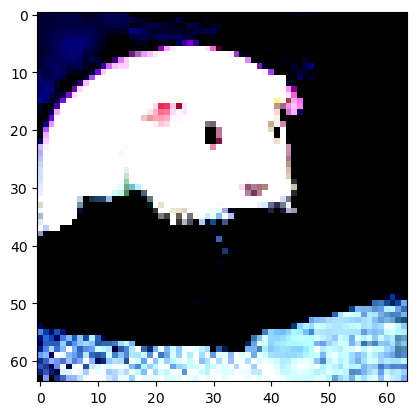

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


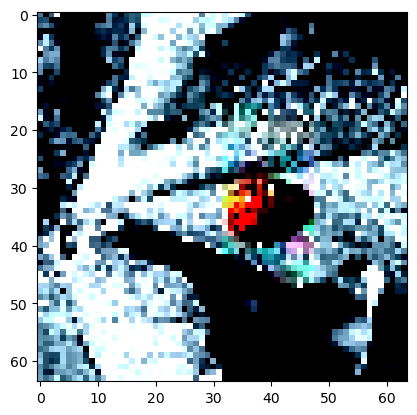

In [13]:
for batch in val_dataloader:
    images, class_nums = batch
    plt.imshow(images[5].permute(1, 2, 0))
    plt.show()
    plt.imshow(images[19].permute(1, 2, 0))
    plt.show()
    break

## Задание 1. 

5 баллов
Добейтесь accuracy на валидации не менее 0.44. В этом задании запрещено пользоваться предобученными моделями и ресайзом картинок.


Для того чтобы выбить скор (считается ниже) на 2.5/5 балла (то есть половину за задание) достаточно соблюдать пару простых жизненных правил:
1. Аугментация (без нее сложно очень будет)
2. Оптимайзеры можно (и нужно) использовать друг с другом. Однако когда что-то проверяете, то не меняйте несколько параметров сразу - собьете логику экспериментов
3. Не используйте полносвязные модели или самые первые сверточные, используйте более современные архитектуры (что на лекциях встречались)
4. Посмотреть все ноутбуки прошедших семинаров и слепить из них что-то общее. Семинарских тетрадок хватит сверх

### Модель (или просто импортируйте не предобученную)

In [8]:
class YourNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = densenet121()
        self.model.classifier = nn.Linear(in_features=1024, out_features=200, bias=True)

        self.loss_func = nn.CrossEntropyLoss()
        self.targets = torch.Tensor()
        self.preds = torch.Tensor()

    def _forward(self, x):
        return self.model(x)

    def forward(self, images, target=None):
        output = self._forward(images)

        if target is not None:
            loss = self.loss_func(output, target)
            self.targets = torch.cat((self.targets, target.cpu()), 0)
            pred = torch.argmax(output, dim=-1)
            self.preds = torch.cat((self.preds, pred.cpu()), 0)
            self.accuracy = accuracy(self.preds.long(), self.targets.long())

        return loss


    def get_accuracy(self, reset=False):
        if reset:
            self.targets = torch.Tensor()
            self.preds = torch.Tensor()
        return self.accuracy

### Тренировочный класс lightning

In [9]:
class YourModule(pl.LightningModule):
    def __init__(self, model, learning_rate, optimizer='Adam', lr_func=None):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.optim = optimizer
        self.lr_func = lr_func

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        if self.optim == 'Adam':
            return torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        elif self.optim == 'LambdaLR':
            optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
            scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=self.lr_func)
            return [optimizer], [scheduler]

    def training_step(self, train_batch, batch_idx):
        images, targets = train_batch
        loss = self.model(images, targets)
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_accuracy', self.model.get_accuracy(reset=True), prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        images, targets = val_batch
        loss = self.model(images, targets)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_accuracy', self.model.get_accuracy(reset=True), prog_bar=True)

In [10]:
wandb_logger = WandbLogger(log_model='all', project='hw2', name='task1_densenet121_1')
checkpoint_callback = ModelCheckpoint(monitor="val_accuracy", mode="max")
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print('Device:', device)

learning_rate = 0.015
optim = 'LambdaLR'
model = YourNet().to(device)
module = YourModule(model, learning_rate, optim, lr_func=lambda epoch: 0.9**epoch)

Device: cuda:0


In [11]:
trainer = pl.Trainer(accelerator='cuda', max_epochs=20, auto_lr_find=True, logger=wandb_logger, default_root_dir='hw2_task1/')    
#trainer.tune(module, train_dataloader, val_dataloader)
trainer.fit(module, train_dataloader, val_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type    | Params
----------------------------------
0 | model | YourNet | 7.2 M 
----------------------------------
7.2 M     Trainable params
0         Non-trainable params
7.2 M     Total params
28.635    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [12]:
module.learning_rate = 3e-7
trainer = pl.Trainer(accelerator='cuda', max_epochs=4, auto_lr_find=True, logger=wandb_logger, default_root_dir='hw2_task1/')    
#trainer.tune(module, train_dataloader, val_dataloader)
trainer.fit(module, train_dataloader, val_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type    | Params
----------------------------------
0 | model | YourNet | 7.2 M 
----------------------------------
7.2 M     Trainable params
0         Non-trainable params
7.2 M     Total params
28.635    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=4` reached.


In [15]:
torch.save(module.model, 'hw2/task1_model_hw2.h')
run = wandb.init(project='hw2')
artifact = wandb.Artifact('task1_model', type='model')
artifact.add_file('hw2/task1_model_hw2.h')
run.log_artifact(artifact)

### Валидация результатов задания

In [14]:
def evaluate_task(model, test_dataloader, device="cuda:0"):
    model = model.to(device)
    model.eval()
    accuracy = 0.0
    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            loss = model(images, labels)
            acc_batch = model.get_accuracy(reset=False)
        accuracy += acc_batch
    accuracy = accuracy / len(test_dataloader)
    return accuracy

In [17]:
run = wandb.init(project='hw2')
datadir = run.use_artifact('task1_model:latest').download()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = torch.load(datadir + '/task1_model_hw2.h')

accuracy = evaluate_task(model, val_dataloader)
print(f"Оценка за это задание составит {np.clip(10 * accuracy / 0.44, 0, 10):.2f} баллов")

wandb:   1 of 1 files downloaded.  
100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:12<00:00,  6.08it/s]

Оценка за это задание составит 8.78 баллов


## Задание 2

5 баллов
Добейтесь accuracy на валидации не менее 0.84. В этом задании делать ресайз и использовать претрейн можно.

Для того чтобы выбить скор (считается ниже) на 2.5/5 балла (то есть половину за задание) достаточно соблюдать пару простых жизненных правил:
1. Аугментация (без нее сложно очень будет)
2. Оптимайзеры можно (и нужно) использовать друг с другом. Однако когда что-то проверяете, то не меняйте несколько параметров сразу - собьете логику экспериментов
3. Не используйте полносвязные модели или самые первые сверточные, используйте более современные архитектуры (что на лекциях встречались или можете пойти дальше).
4. Попробуйте сначала посмотреть качество исходной модели без дообучения, сохраните как baseline. Отсюда поймете какие слои нужно дообучать.
5. Посмотреть все ноутбуки прошедших семинаров и слепить из них что-то общее. Семинарских тетрадок хватит сверх

**Второе задание я делал в Colab (с другой почты), так как моя gpu не спровлялась. Ссылка на последней эксперемент [тык](https://colab.research.google.com/drive/1OjRPUvRc6cIoRcCs-UBfI2BW-uxrH8aO#scrollTo=PEdwJE5uOrIM).**

In [15]:
batch_size=64
train_transform = Compose([ToTensor(), Normalize(mean, std), Resize(224)])
val_transform = Compose([ToTensor(), Normalize(mean, std), Resize(224)])

train_dataset = ImageFolder('dataset/dataset/train', transform=train_transform)
val_dataset = ImageFolder('dataset/dataset/val', transform=val_transform)
# REPLACE ./dataset/dataset WITH THE FOLDER WHERE YOU DOWNLOADED AND UNZIPPED THE DATASET

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

### Модель (или просто импортируйте предобученную)

In [20]:
class YourNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False
        self.model.head = nn.Linear(in_features=768, out_features=512, bias=True)
        self.bn = nn.BatchNorm1d(512)
        self.fc = nn.Linear(in_features=512, out_features=200, bias=True)

        self.loss_func = nn.CrossEntropyLoss()
        self.targets = torch.Tensor()
        self.preds = torch.Tensor()

    def _forward(self, x):
        return self.fc(self.bn(self.model(x)))

    def forward(self, images, target=None):
        output = self._forward(images)
        if target is not None:
            loss = self.loss_func(output, target)
            self.targets = torch.cat((self.targets, target.cpu()), 0)
            pred = torch.argmax(output, dim=-1)
            self.preds = torch.cat((self.preds, pred.cpu()), 0)
            self.accuracy = accuracy(self.preds.long(), self.targets.long())

        return loss


    def get_accuracy(self, reset=False):
        if reset:
            self.targets = torch.Tensor()
            self.preds = torch.Tensor()
        return self.accuracy

### Тренировочный класс lightning

In [21]:
class YourModule(pl.LightningModule):
    def __init__(self, model, learning_rate, optimizer='Adam', lr_func=None):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.optim = optimizer
        self.lr_func = lr_func

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        if self.optim == 'Adam':
            return torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        elif self.optim == 'LambdaLR':
            optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
            scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=self.lr_func)
            return [optimizer], [scheduler]
        elif self.optim == 'Adagrad':
            return torch.optim.Adagrad(self.model.parameters(), lr=self.learning_rate, lr_decay=0.01)

    def training_step(self, train_batch, batch_idx):
        images, targets = train_batch
        loss = self.model(images, targets)
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_accuracy', self.model.get_accuracy(reset=True), prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        images, targets = val_batch
        loss = self.model(images, targets)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_accuracy', self.model.get_accuracy(reset=True), prog_bar=True)

In [50]:
wandb_logger = WandbLogger(log_model='all', project='hw2', name='vit2')
checkpoint_callback = ModelCheckpoint(monitor="val_accuracy", mode="max")
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print('Device:', device)

learning_rate = 0.02
optim = 'LambdaLR'
model = YourNet().to(device)
module = YourModule(model, learning_rate, optim, lr_func=lambda e: 0.7**e)

Device: cuda:0


### Валидация результатов задания

In [16]:
!wandb login --relogin a54b729f7b046783833e7b1f490eba1ea25450ad

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\pld02/.netrc


In [17]:
!wandb login

wandb: Currently logged in as: lentohrastik2. Use `wandb login --relogin` to force relogin


In [22]:
run = wandb.init(project='hw2')
datadir = run.use_artifact('task2_model:latest').download()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = torch.load(datadir + '/task2_model_hw2.h')
accuracy = evaluate_task(model, val_dataloader)
print(f"Оценка за это задание составит {np.clip(10 * (accuracy - 0.5) / 0.34, 0, 10):.2f} баллов")

wandb: Downloading large artifact task2_model:latest, 329.28MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.0
100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [04:48<00:00,  1.84s/it]

Оценка за это задание составит 9.45 баллов


# Отчёт об экспериментах 

текст писать тут (или ссылочку на wandb/любой трекер экспреиментов) для каждого задания, то есть не обязательно именно тут рисовать графики, если вы используете готовые трекеры/мониторинги ваших моделей.

Првое здание - runs начинаются с 'task1', все остольные runs - это 2 задание. [Ссылка1](https://wandb.ai/lentohrastik/hw2), [Ссылка2](https://wandb.ai/lentohrastik2/hw2?workspace=user-lentohrastik2)